<a href="https://colab.research.google.com/github/rjaa2020/projects/blob/main/Hexxed_Neuronav_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://rjaa2020@github.com/rjaa2020/hexxed_neuronav.git
%cd hexxed_neuronav

Cloning into 'hexxed_neuronav'...
remote: Enumerating objects: 944, done.
remote: Counting objects: 100% (563/563), done.
remote: Compressing objects: 100% (364/364), done.
remote: Total 944 (delta 328), reused 341 (delta 193), pack-reused 381
Receiving objects: 100% (944/944), 42.51 MiB | 15.33 MiB/s, done.
Resolving deltas: 100% (469/469), done.
/content/hexxed_neuronav


In [2]:
import math
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from copy import deepcopy

In [3]:
# from neuronav.agents.rahul_hybrid_agent import HybridAgent

from neuronav.agents.dyna_agents import DynaQ
from neuronav.agents.td_agents import TDQ, SARSA, TDAC
from neuronav.agents.mc_agents import QMC
from neuronav.envs.graph_env import GraphEnv, GraphObservation
from neuronav.envs.graph_templates import GraphTemplate, HexxedGraph
from neuronav.utils import run_episode

In [4]:
g = HexxedGraph()
g.visualize()

                     00
 1  2  3  4  5  6 |  07    <--  Layer 01
 8  9 10 11 12 13 |  14    <--  Layer 02
15 16 17 18 19 20 |  21    <--  Layer 03
22 23 24 25 26 27 |  28    <--  Layer 04
29 30 31 32 33 34 |  35    <--  Layer 05
36 37 38 39 40 41 |  42    <--  Layer 06
                     43


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# helper functions

In [5]:
def plot_learning_curves(learning_curves):
  learning_curves = pd.DataFrame(learning_curves)

  # Create subplots with a shared x-axis
  fig, axes = plt.subplots(nrows=1, ncols=len(learning_curves.columns), figsize=(15, 5), sharex=True)

  # Iterate over columns and plot histograms
  for i, column in enumerate(learning_curves.columns):
      learning_curves[column].hist(bins=8, alpha=0.7, ax=axes[i], edgecolor='black')
      axes[i].set_title(column)

  # Set common labels and title
  plt.suptitle('Reward Distribution of each Agent')
  plt.xlabel('Reward')
  plt.ylabel('Frequency')

  plt.show()


# training the agents

## manually setting shared agent hyperparams

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TDQ Episode 0 ==> 0.00% complete
TDQ Episode 10 ==> 20.00% complete
TDQ Episode 20 ==> 40.00% complete
TDQ Episode 30 ==> 60.00% complete
TDQ Episode 40 ==> 80.00% complete
DynaQ Episode 0 ==> 0.00% complete
DynaQ Episode 10 ==> 20.00% complete
DynaQ Episode 20 ==> 40.00% complete
DynaQ Episode 30 ==> 60.00% complete
DynaQ Episode 40 ==> 80.00% complete
SARSA Episode 0 ==> 0.00% complete
SARSA Episode 10 ==> 20.00% complete
SARSA Episode 20 ==> 40.00% complete
SARSA Episode 30 ==> 60.00% complete
SARSA Episode 40 ==> 80.00% complete


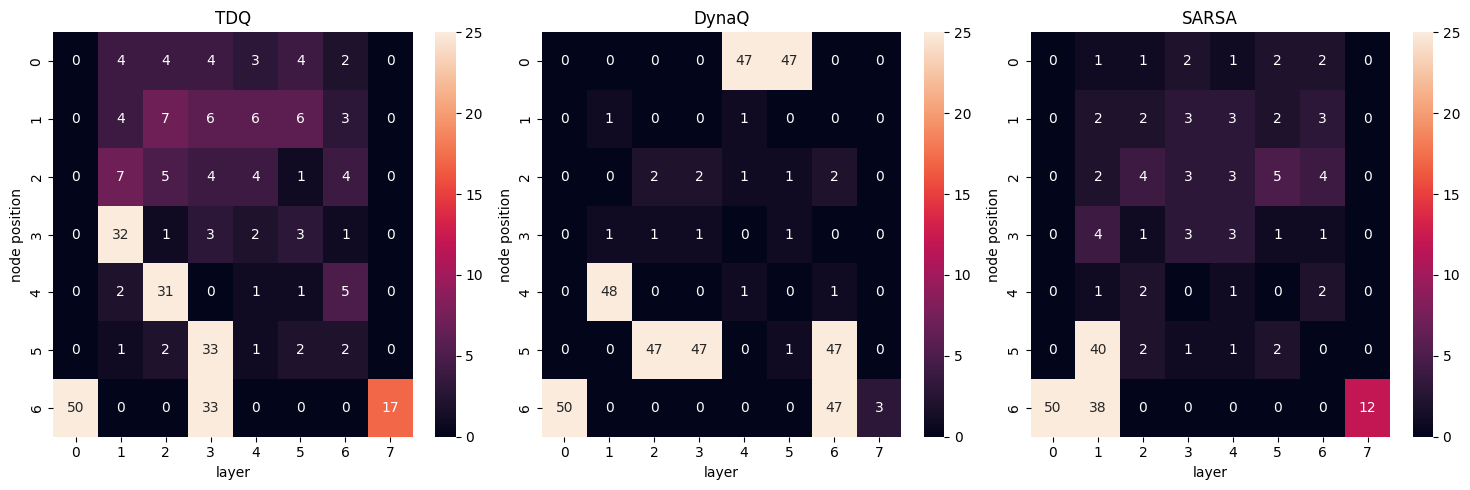

In [33]:
NUM_EPS = 50
MAX_STEPS = 8

env = GraphEnv(GraphTemplate.hexxed,
			   obs_type=GraphObservation.index)
obs = env.reset()

# model params
model_params_shared = {
    "state_size" : env.state_size,
    "action_size": env.action_space.n,
    "epsilon" : 0.1, # between 0 (explore) to 1 (exploit)
    "lr" : 0.5, # between [0, 1], higher means more weight on learned rewards
    "beta": 100}

agents = {
	"TDQ": TDQ(**model_params_shared),
	"DynaQ": DynaQ(**model_params_shared),
  # "QMC" : QMC(**model_params_shared),
  # "TDAC": TDAC(**model_params_shared),
	"SARSA": SARSA(**model_params_shared),
}

# agents = {"Hybrid": HybridAgent(state_size=env.state_size, action_size=env.action_space.n)}

learning_curves = defaultdict(list)

num_agents = len(agents.keys())

fig, axs = plt.subplots(ncols = num_agents, figsize=(5*num_agents, 5))

for agent_num, agent_name in enumerate(agents.keys()):

	agent = agents[agent_name]
	state_diagram = np.zeros((env.state_size, MAX_STEPS))

	for i in range(NUM_EPS):
		if i % 10 == 0: print(f"{agent_name} Episode {i} ==> {float(i) / NUM_EPS:.02%} complete")
		agent, steps, ep_return, moves = run_episode(env=env,
													 agent=agent,
													 max_steps=MAX_STEPS,
													 return_moves=True)

		moves_arr = (np.eye(env.state_size)[moves].T)

		moves_h, moves_w = moves_arr.shape
		state_diagram[: moves_h, : moves_w] += moves_arr

		learning_curves[agent_name].append(ep_return)

	axs[agent_num].set_title("Agent Traversals")
	axs[agent_num].set_xlabel("layer")
	axs[agent_num].set_xlabel("node position")

	# plotting the traversals
	square_state_diagram = np.zeros((8, 8))

	# the mapping from flat state diagram to square
	layers_map = {n: (math.ceil(n / 7), n % 7) if n % 7 != 0 else (math.ceil(n / 7), 7) for n in range(43)}
	layers_map[43] = (7, 7)

	flat_state_diagram = np.sum(state_diagram, axis=1)

	for n in range(flat_state_diagram.shape[0]):
		layer, pos = layers_map[n]
		square_state_diagram[pos, layer] = flat_state_diagram[n]

	sns.heatmap(square_state_diagram[1:], annot=True, vmax=25, ax=axs[agent_num])
	axs[agent_num].set_xlabel('layer')
	axs[agent_num].set_ylabel('node position')
	axs[agent_num].set_title(agent_name)

	fig.tight_layout()

## Testing different hyperparams

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import seaborn as sns

MAX_STEPS = 8
NUM_EPS = 20
NUM_INSTANCES = 5  # Number of instantiations

env = GraphEnv(GraphTemplate.hexxed,
               obs_type=GraphObservation.index)
obs = env.reset()

# model params
model_params_shared = {
    "state_size": env.state_size,
    "action_size": env.action_space.n,
    "epsilon": 0.1,  # between 0 (explore) to 1 (exploit)
}
agents = {
    "TDQ": TDQ(**model_params_shared),
    "DynaQ": DynaQ(**model_params_shared),
    # "QMC": QMC(**model_params_shared),
    # "TDAC": TDAC(**model_params_shared),
    "SARSA": SARSA(**model_params_shared),
}

learning_curves = defaultdict(list)
num_agents = len(agents.keys())

# Define hyperparameters and their ranges
hyperparameters = {
    'learning_rate': {'range': np.arange(0, 1.1, 0.1)},
    'gamma': {'range': np.arange(0, 1.1, 0.1)},
    'epsilon': {'range': np.arange(0, 1.1, 0.1)}
}

obs = env.reset()
num_agents = len(agents.keys())
learning_curves = defaultdict(list)
best_params = defaultdict(dict)

# Create arrays to store the results for each agent
heatmap_data = {agent_name: np.zeros(tuple(len(hp['range']) for hp in hyperparameters.values())) for agent_name in agents.keys()}

# Iterate over each agent
for agent_num, agent_name in enumerate(agents.keys()):
    best_mean_score = 0

    # Generate all combinations of hyperparameters
    for indices in np.ndindex(heatmap_data[agent_name].shape):
        # Get hyperparameter name, index, and value for current run
        hyperparameter_values = {hp_name: hp['range'][idx] for hp_name, idx, hp in zip(hyperparameters.keys(), indices, hyperparameters.values())}

        # Run multiple instantiations of the agent
        instantiation_scores = []

        for _ in range(NUM_INSTANCES):
            # Instantiate a new agent for each iteration
            agent = deepcopy(agents[agent_name])

            for hp_name, value in hyperparameter_values.items():
                setattr(agent, hp_name, value)

            # Begin running episodes
            episode_returns = []

            # Run episodes
            for i in range(NUM_EPS):
                agent, steps, ep_return, moves = run_episode(env=env, agent=agent, max_steps=MAX_STEPS, return_moves=True)
                episode_returns.append(ep_return)

            mean_score = np.mean(np.sqrt(episode_returns))
            instantiation_scores.append(mean_score)

        # Compute the average score over the instantiations
        mean_score = np.mean(instantiation_scores)

        # Store mean score in the heatmap data
        heatmap_data[agent_name][indices] = mean_score

        if mean_score > best_mean_score:
            best_mean_score = mean_score
            best_params[agent_name] = hyperparameter_values
            print(f"New best {agent_name} params found with mean score of {mean_score:0.3f}: {best_params[agent_name]}")

        # else:
        #     print(f"{agent_name} with params {hyperparameter_values} found mean score of {mean_score}", end='\r')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


New best TDQ params found with mean score of 1.240: {'learning_rate': 0.0, 'gamma': 0.0, 'epsilon': 0.0}
New best TDQ params found with mean score of 1.260: {'learning_rate': 0.0, 'gamma': 0.0, 'epsilon': 0.2}
New best TDQ params found with mean score of 1.300: {'learning_rate': 0.0, 'gamma': 0.0, 'epsilon': 0.5}
New best TDQ params found with mean score of 1.580: {'learning_rate': 0.0, 'gamma': 0.0, 'epsilon': 0.9}
New best TDQ params found with mean score of 1.820: {'learning_rate': 0.0, 'gamma': 0.1, 'epsilon': 0.0}
New best TDQ params found with mean score of 1.880: {'learning_rate': 0.0, 'gamma': 0.1, 'epsilon': 0.4}
New best TDQ params found with mean score of 2.210: {'learning_rate': 0.0, 'gamma': 0.2, 'epsilon': 0.8}
New best TDQ params found with mean score of 2.260: {'learning_rate': 0.1, 'gamma': 1.0, 'epsilon': 1.0}
New best TDQ params found with mean score of 2.440: {'learning_rate': 0.5, 'gamma': 0.4, 'epsilon': 0.8}
New best TDQ params found with mean score of 2.520: {'l

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


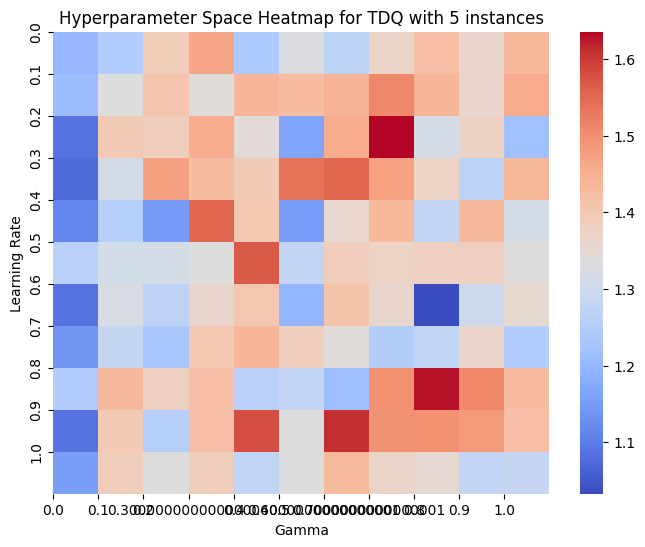

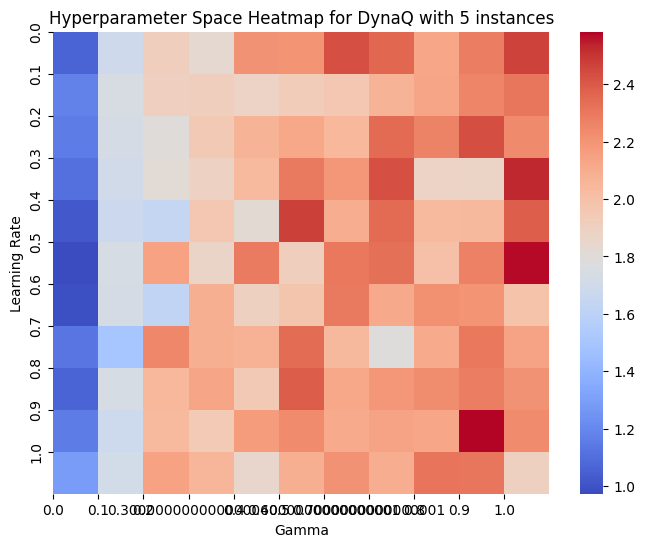

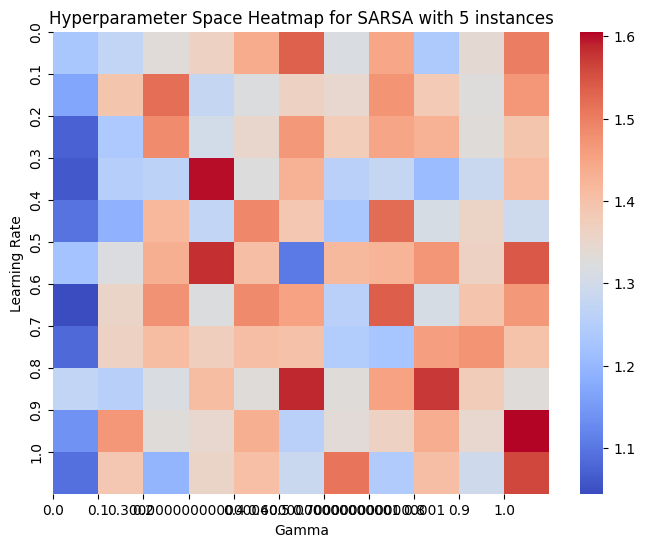

In [23]:
# Plotting the heatmap for each agent
for agent_name, data in heatmap_data.items():
    data = np.mean(data, axis=2)
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, cmap='coolwarm', fmt=".2f", cbar=True)
    plt.xlabel('Gamma')
    plt.ylabel('Learning Rate')
    plt.title(f'Hyperparameter Space Heatmap for {agent_name} with {NUM_INSTANCES} instances')
    plt.xticks(np.arange(len(hyperparameters['gamma']['range'])), hyperparameters['gamma']['range'])
    plt.yticks(np.arange(len(hyperparameters['learning_rate']['range'])), ["{:.1f}".format(lr) for lr in hyperparameters['learning_rate']['range']])
    plt.show()


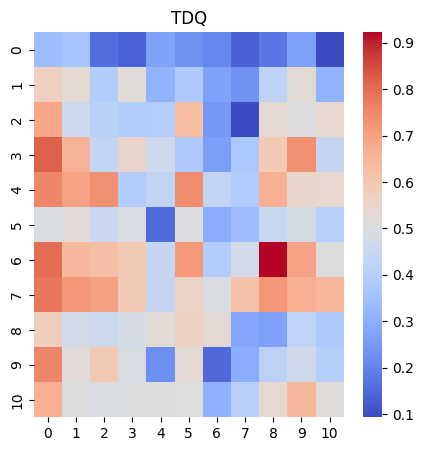

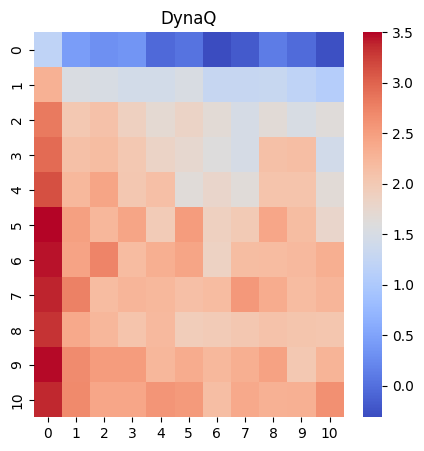

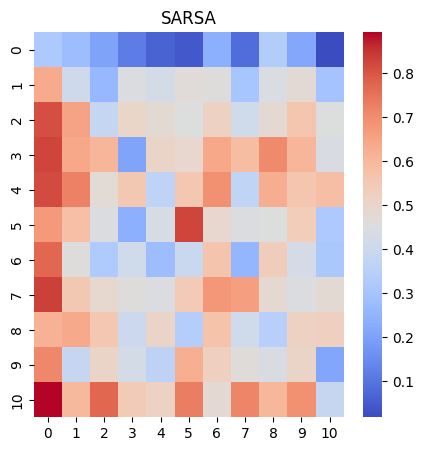

In [24]:
for agent in heatmap_data.keys():
    agent_data = np.mean(heatmap_data[agent], axis=2)
    lr_avgs = np.mean(agent_data, axis=0)
    beta_avgs = np.mean(agent_data, axis=1)
    null_data = np.reshape(lr_avgs, (-1, 1)) @ np.reshape(beta_avgs, (1, -1))

    fig, ax = plt.subplots(figsize=(5,5))
    plt.title(f"{agent}")
    sns.heatmap(null_data - agent_data, cmap='coolwarm')

    # fig, axs = plt.subplots(nrows=2, ncols=1, sharey=True, figsize=(10, 5))

    # plt.suptitle(f'Hyperparameter Averages for {agent} with {NUM_INSTANCES} instances')
    # axs[0].set_xlabel('Beta')
    # axs[1].set_xlabel('Learning Rate')


    # axs[0].plot(lr_avgs)
    # axs[0].set_xticks(np.arange(len(hyperparameters['beta']['range'])))
    # axs[0].set_xticklabels(hyperparameters['beta']['range'])  # Set the labels

    # axs[1].plot(beta_avgs)
    # axs[1].set_xticks(np.arange(len(hyperparameters['learning_rate']['range'])))
    # axs[1].set_xticklabels(["{:.1f}".format(lr) for lr in hyperparameters['learning_rate']['range']])  # Set the labels

    # plt.tight_layout()

    # break  # This breaks the loop after the first iteration, not sure if intended


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


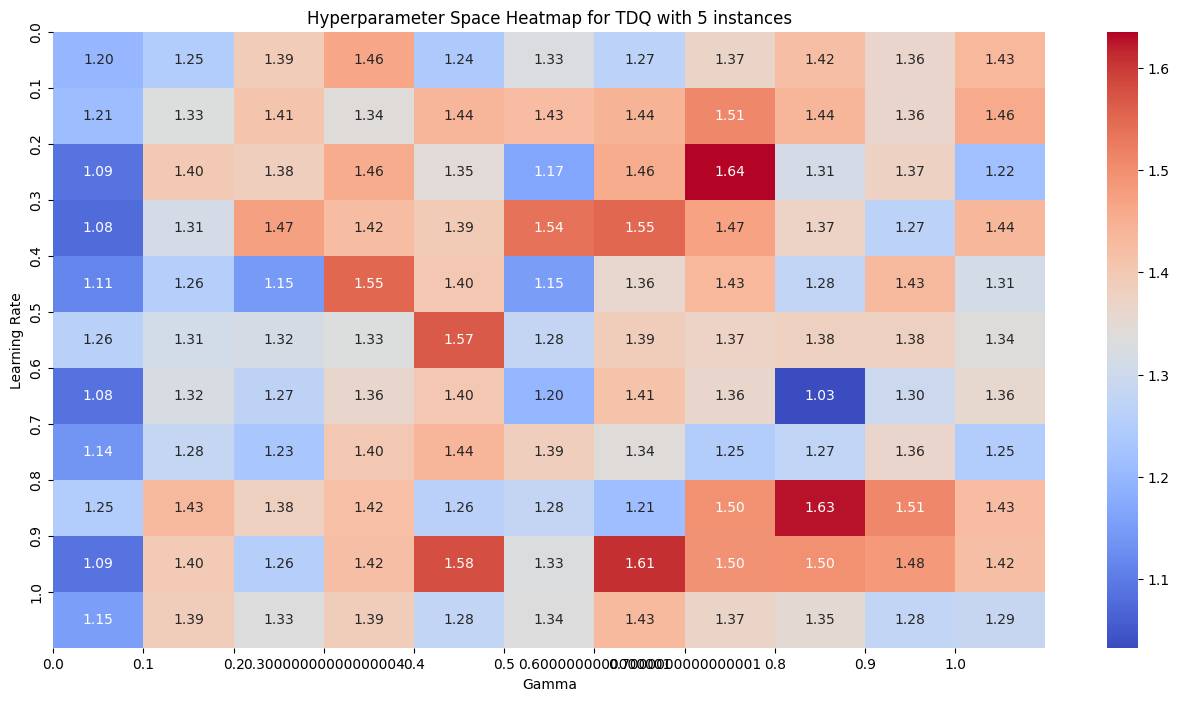

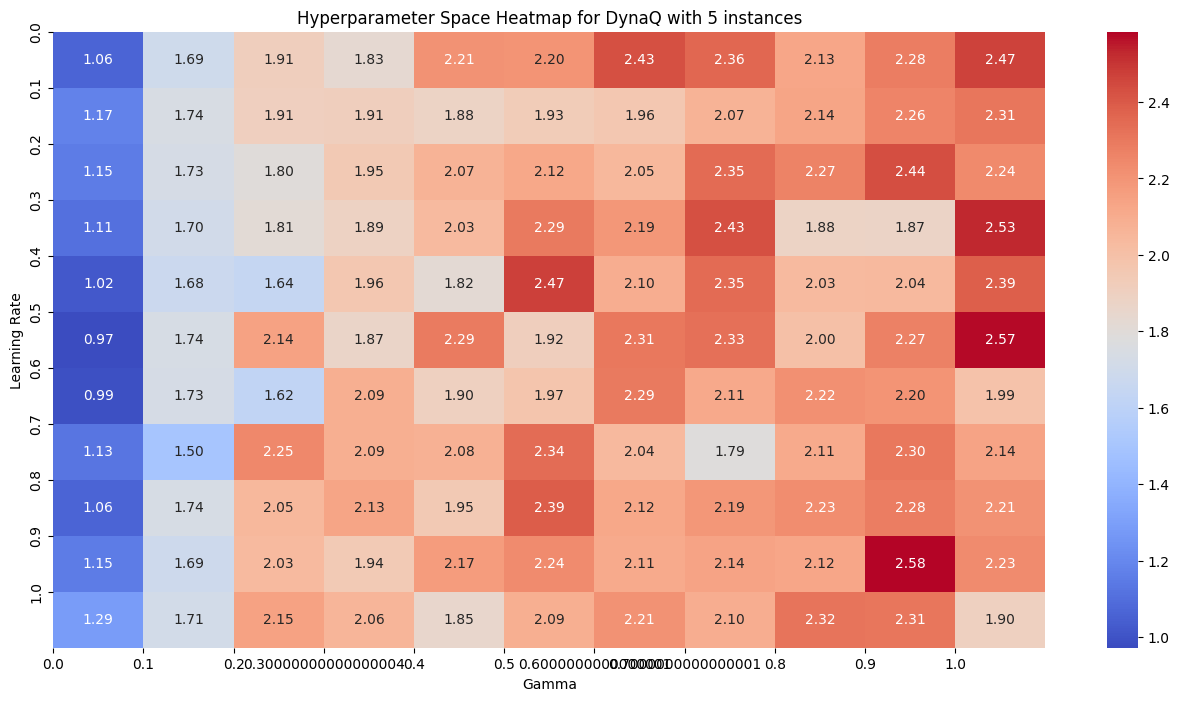

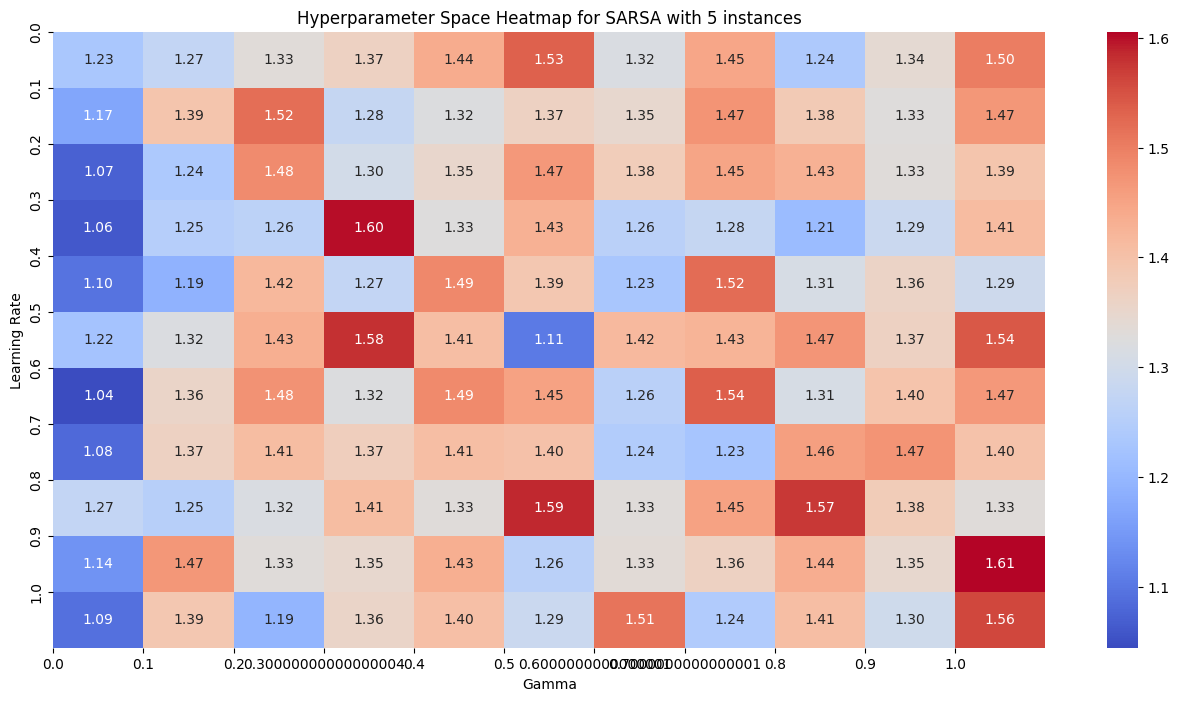

In [25]:
# Plotting the heatmap for each agent
for agent_name, data in heatmap_data.items():
    data = np.mean(data, axis=2)
    plt.figure(figsize=(16,8))
    sns.heatmap(data, cmap='coolwarm', annot=True, fmt=".2f", cbar=True)
    plt.xlabel('Gamma')
    plt.ylabel('Learning Rate')
    plt.title(f'Hyperparameter Space Heatmap for {agent_name} with {NUM_INSTANCES} instances')
    plt.xticks(np.arange(len(hyperparameters['gamma']['range'])), hyperparameters['gamma']['range'])
    plt.yticks(np.arange(len(hyperparameters['learning_rate']['range'])), ["{:.1f}".format(lr) for lr in hyperparameters['learning_rate']['range']])
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


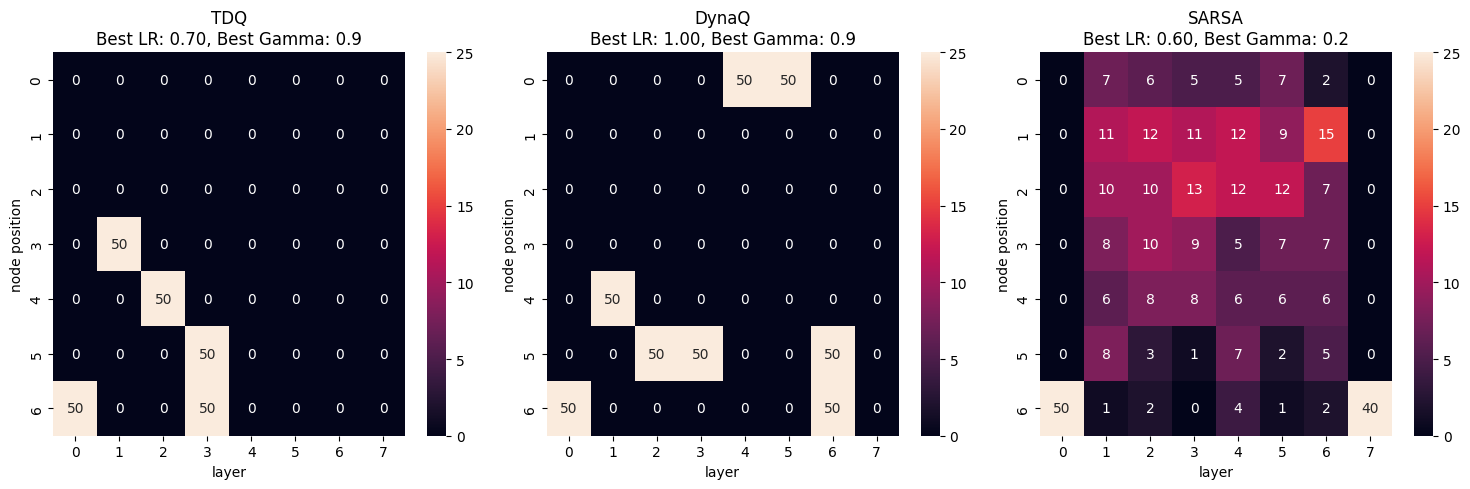

In [34]:
fig, axs = plt.subplots(ncols=num_agents, figsize=(5 * num_agents, 5))

# learning_curves = defaultdict(list)

for agent_num, agent_name in enumerate(agents.keys()):
    # After finding the best params, train the agent with those params
    agent = deepcopy(agents[agent_name])
    agent.lr = best_params[agent_name]["learning_rate"]
    agent.beta = best_params[agent_name]["gamma"]  # Use the best beta value

    state_diagram = np.zeros((env.state_size, MAX_STEPS))

    for i in range(NUM_EPS):
        agent, steps, ep_return, moves = run_episode(env=env, agent=agent, max_steps=MAX_STEPS, return_moves=True)
        moves_arr = (np.eye(env.state_size)[moves].T)
        moves_h, moves_w = moves_arr.shape
        state_diagram[: moves_h, : moves_w] += moves_arr
        learning_curves[agent_name].append(ep_return)

    axs[agent_num].set_title("Agent Traversals")
    axs[agent_num].set_xlabel("layer")
    axs[agent_num].set_xlabel("node position")

    # plotting the traversals
    square_state_diagram = np.zeros((8, 8))

    layers_map = {n: (math.ceil(n / 7), n % 7) if n % 7 != 0 else (math.ceil(n / 7), 7) for n in range(43)}
    layers_map[43] = (7, 7)

    flat_state_diagram = np.sum(state_diagram, axis=1)

    for n in range(flat_state_diagram.shape[0]):
        layer, pos = layers_map[n]
        square_state_diagram[pos, layer] = flat_state_diagram[n]

    sns.heatmap(square_state_diagram[1:], annot=True, vmax=25, ax=axs[agent_num])
    axs[agent_num].set_xlabel('layer')
    axs[agent_num].set_ylabel('node position')
    axs[agent_num].set_title(f"{agent_name}\nBest LR: {best_params[agent_name]['learning_rate']:.02f}, Best Gamma: {best_params[agent_name]['gamma']:03}")

fig.tight_layout()

# Analyzing Results

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


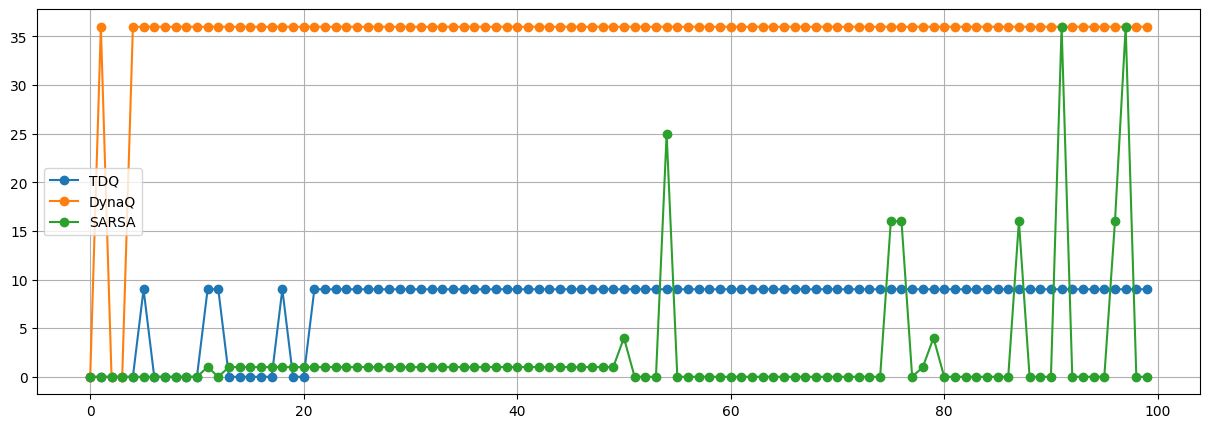

In [35]:
fig, ax = plt.subplots(figsize=(15, 5))

for agent_name in learning_curves:
  learning_curve = learning_curves[agent_name]
  ax.plot(range(len(learning_curve)), learning_curve, marker='o', label=agent_name)
  ax.legend(loc='best')
  ax.grid()

# Testing Deep Agents

In [ ]:
raise NotImplementedError("The following Deep Agents don't work yet")

NotImplementedError: The following Deep Agents don't work yet

In [ ]:
from neuronav.deep_agents.ppo.agent import PPOAgent

In [ ]:
env = GraphEnv(GraphTemplate.hexxed,
			   obs_type=GraphObservation.index)
obs = env.reset()

env.render()

In [ ]:
repeats = 3
episodes = 500
max_steps = 100
algo = "ppo"  # "sac" or "ppo"

agent_params_sac = {
    "batch_size": 32,
    "gamma": 0.99,
    "tau": 0.005,
    "target_update_interval": 4,
    "replay_buffer_size": 100000,
    "update_interval": 4,
    "warmup_steps": 1000,
    "alpha": 0.02,
}

agent_params_ppo = {
    "gamma": 0.99,
    "lambda": 0.95,
    "buffer_size": 256,
    "ent_coef": 0.02,
    "num_passes": 2,
    "clip_param": 0.2,
    "batch_size": 32,
}

In [ ]:
# Training loop. We run the agent for a number of episodes and repeat this process a number of times.

def get_model_params(env):
    if env.obs_mode in visual64_types:
        enc_type = "conv64"
    elif env.obs_mode in visual32_types:
        enc_type = "conv32"
    else:
        enc_type = "linear"
    model_params = {
        "enc_type": enc_type,
        "h_size": 128,
        "lr": 3e-4,
        "obs_size": math.prod(env.obs_space.shape),
        "act_size": env.action_space.n,
        "depth": 3,
    }
    return model_params

all_returns = []
for i in range(repeats):
    ep_returns = []
    model_params = get_model_params(env)
    if algo == "ppo":
        agent = PPOAgent(model_params, agent_params_ppo)
    elif algo == "sac":
        agent = SACAgent(model_params, agent_params_sac)
    else:
        raise NotImplementedError
    for j in range(episodes):
        agent, ep_steps, ep_return = run_episode(
            env, agent, max_steps, time_penalty=-0.01
        )
        ep_returns.append(ep_return)
    all_returns.append(ep_returns)

In [ ]:
env = GraphEnv(GraphTemplate.hexxed,
			   obs_type=GraphObservation.index)
obs = env.reset()

# model params
deep_env_params_shared = {
    "batch_size" : 32,
    "learning_rate" : 3e-4,
    "h_size" : 128
}

ppo_params = {
    "gamma" : 0.99,
    "lambda" : 0.95,
    "clip_param" : 0.2,
    "buffer_size" : 256,
    "num_passes" : 2,
    "ent_coefficient" : 0.02
}

agents = {
	"PPO": PPOAgent(deep_env_params_shared, ppo_params)
 }

learning_curves = defaultdict(list)

num_agents = len(agents.keys())

In [ ]:
fig, axs = plt.subplots(ncols = num_agents, figsize=(5*num_agents, 5))

for agent_num, agent_name in enumerate(agents.keys()):

	agent = agents[agent_name]
	state_diagram = np.zeros((env.state_size, MAX_STEPS))

	for i in range(NUM_EPS):
		print(f"{agent_name} Episode {i} ==> {float(i) / NUM_EPS:.02%} complete")
		agent, steps, ep_return, moves = run_episode(env=env,
													 agent=agent,
													 max_steps=MAX_STEPS,
													 return_moves=True)

		moves_arr = (np.eye(env.state_size)[moves].T)

		moves_h, moves_w = moves_arr.shape
		state_diagram[: moves_h, : moves_w] += moves_arr

		learning_curves[agent_name].append(ep_return)

	axs[agent_num].set_title("Agent Traversals")
	axs[agent_num].set_xlabel("layer")
	axs[agent_num].set_xlabel("node position")

	# plotting the traversals
	square_state_diagram = np.zeros((8, 8))

	# the mapping from flat state diagram to square
	layers_map = {n: (math.ceil(n / 7), n % 7) if n % 7 != 0 else (math.ceil(n / 7), 7) for n in range(43)}
	layers_map[43] = (7, 7)

	flat_state_diagram = np.sum(state_diagram, axis=1)

	for n in range(flat_state_diagram.shape[0]):
		layer, pos = layers_map[n]
		square_state_diagram[pos, layer] = flat_state_diagram[n]

	sns.heatmap(square_state_diagram[1:], annot=True, vmax=25, ax=axs[agent_num])
	axs[agent_num].set_xlabel('layer')
	axs[agent_num].set_ylabel('node position')
	axs[agent_num].set_title(agent_name)

	fig.tight_layout()